In [0]:
dbutils.library.restartPython()

# Actividad 2: Ingesta y Procesamiento en Databricks (Free Edition)
**Dataset:** Fertility Data Set (Diagnosis Prediction)
**Ubicación:** Unity Catalog Volumes (/Volumes/workspace/taller/taller/fertility.csv)

## Objetivo
Cargar datos de fertilidad desde almacenamiento de volúmenes, aplicar un esquema estructurado y comparar procesamiento Spark vs SQL.

## 1. Diseño del Esquema

El dataset `fertility.csv` contiene diagnósticos de fertilidad con datos demográficos y de hábitos de salud.

**Entidades y Campos Clave (Originales):**
* `Season` (String): Estación del año.
* `Age` (Integer): Edad del paciente (ej. 30, 35).
* `Childish diseases` (String): ¿Tuvo enfermedades infantiles? (yes/no).
* `Accident or serious trauma` (String): ¿Tuvo accidentes graves? (yes/no).
* `Surgical intervention` (String): ¿Tuvo cirugías? (yes/no).
* `High fevers in the last year` (String): Frecuencia de fiebres recientes.
* `Frequency of alcohol consumption` (String): Consumo de alcohol.
* `Smoking habit` (String): Hábito de fumar.
* `Number of hours spent sitting per day` (Integer): Horas de sedentarismo.
* `Diagnosis` (String): Diagnóstico final (Normal/Altered).

**Diagrama del Esquema Propuesto (Normalizado):**
```mermaid
erDiagram
    FERTILITY {
        string season
        int age
        string childish_diseases
        string trauma
        string surgery
        string fevers
        string alcohol
        string smoking
        int sitting_hours
        string diagnosis
    }

## 2. Configuración y Evidencia de la Infraestructura

A continuación, se imprime la configuración del entorno en tiempo de ejecución.
*Nota: Al usar Databricks Free Edition, la infraestructura es Serverless y gestionada automáticamente por Databricks.*

In [0]:
import sys

print("=== Configuración del Entorno (Serverless) ===")
print(f"Python Version: {sys.version.split()[0]}")
print(f"Spark Version: {spark.version}")

print("\n=== Detalles de la Sesión ===")
# En Serverless no podemos acceder a spark.sparkContext.appName
# Recuperamos el nombre de la aplicación desde la configuración de la sesión
try:
    app_name = spark.conf.get("spark.app.name")
    print(f"App Name: {app_name}")
except:
    print("App Name: Databricks Shell (Serverless)")

print("\n=== Evidencia de Recursos Asignados (Estimación) ===")
# En Serverless no podemos ver los nodos físicos, pero podemos ver la configuración SQL activa
# Esto sirve como evidencia de que el motor está respondiendo
print("Listando las primeras 5 configuraciones activas de Spark SQL:")
spark.sql("SET").select("key", "value").limit(5).show(truncate=False)

=== Configuración del Entorno (Serverless) ===
Python Version: 3.12.3
Spark Version: 4.0.0

=== Detalles de la Sesión ===
App Name: Databricks Shell (Serverless)

=== Evidencia de Recursos Asignados (Estimación) ===
Listando las primeras 5 configuraciones activas de Spark SQL:
+----------------------------------+-----+
|key                               |value|
+----------------------------------+-----+
|spark.databricks.execution.timeout|9000 |
|spark.sql.ansi.enabled            |true |
|spark.sql.shuffle.partitions      |auto |
+----------------------------------+-----+



## 3. Obtención de Datos y Creación de Tabla

Se cargará el archivo `fertility.csv` ubicado en **Unity Catalog Volumes**.
Se aplica un esquema estricto (`StructType`) con los nombres originales del CSV, y luego se transforman las columnas.

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# 1. Ruta del archivo en Volumes (Ajustada a tu entorno)
file_path = "/Volumes/workspace/taller/taller/fertility.csv"

# 2. Definición del Esquema RAW
raw_schema = StructType([
    StructField("Season", StringType(), True),
    StructField("Age", IntegerType(), True),
    StructField("Childish diseases", StringType(), True),
    StructField("Accident or serious trauma", StringType(), True),
    StructField("Surgical intervention", StringType(), True),
    StructField("High fevers in the last year", StringType(), True),
    StructField("Frequency of alcohol consumption", StringType(), True),
    StructField("Smoking habit", StringType(), True),
    StructField("Number of hours spent sitting per day", IntegerType(), True),
    StructField("Diagnosis", StringType(), True)
])

# 3. Ingesta (Lectura)
try:
    df_raw = spark.read.format("csv") \
        .option("header", "true") \
        .schema(raw_schema) \
        .load(file_path)
    
    print(f"✅ Archivo cargado desde: {file_path}")
except Exception as e:
    print("❌ Error cargando archivo. Verifica la ruta.")
    raise e

# 4. Transformación y Limpieza (Renombrado de columnas)
df_fertility = df_raw \
    .withColumnRenamed("Childish diseases", "childish_diseases") \
    .withColumnRenamed("Accident or serious trauma", "trauma") \
    .withColumnRenamed("Surgical intervention", "surgery") \
    .withColumnRenamed("High fevers in the last year", "fevers") \
    .withColumnRenamed("Frequency of alcohol consumption", "alcohol") \
    .withColumnRenamed("Smoking habit", "smoking") \
    .withColumnRenamed("Number of hours spent sitting per day", "sitting_hours") \
    .withColumnRenamed("Season", "season") \
    .withColumnRenamed("Age", "age") \
    .withColumnRenamed("Diagnosis", "diagnosis")

# 5. Persistencia (Vista Temporal para SQL)
df_fertility.createOrReplaceTempView("fertility_clean")
print("✅ Vista temporal 'fertility_clean' creada exitosamente.")

# Evidencia
display(df_fertility.limit(3))

✅ Archivo cargado desde: /Volumes/workspace/taller/taller/fertility.csv
✅ Vista temporal 'fertility_clean' creada exitosamente.


season,age,childish_diseases,trauma,surgery,fevers,alcohol,smoking,sitting_hours,diagnosis
spring,30,no,yes,yes,more than 3 months ago,once a week,occasional,16,Normal
spring,35,yes,no,yes,more than 3 months ago,once a week,daily,6,Altered
spring,27,yes,no,no,more than 3 months ago,hardly ever or never,never,9,Normal


## 4. Validaciones en Spark y SQL

A continuación realizaremos consultas equivalentes en ambos lenguajes para validar integridad, tipos de datos y reglas de negocio.__

In [0]:
from pyspark.sql.functions import col, count, avg

print("=== INICIO DEL PUNTO 4: VALIDACIONES CRUZADAS (SPARK VS SQL) ===")

# ---------------------------------------------------------
# SUBPUNTO 4.1: METADATOS Y ESTRUCTURA
# Objetivo: Verificar que los tipos de datos (Enteros vs Strings) se cargaron bien.
# ---------------------------------------------------------
print("\n>>> 4.1. Validando Metadatos")

print("[Spark] Esquema del DataFrame:")
df_fertility.printSchema()

print("[SQL] Descripción de la Tabla (vía spark.sql):")
# Usamos display() para que se vea bonito en formato tabla
display(spark.sql("DESCRIBE fertility_clean"))


# ---------------------------------------------------------
# SUBPUNTO 4.2: ESTADÍSTICAS DESCRIPTIVAS
# Objetivo: Analizar rangos numéricos. ¿Son coherentes las edades y horas sentado?
# ---------------------------------------------------------
print("\n>>> 4.2. Análisis Estadístico (Data Quality)")
print("Revisamos distribución de Edad y Horas de Sedentarismo:")

# En Spark
df_fertility.select("age", "sitting_hours").describe().show()


# ---------------------------------------------------------
# SUBPUNTO 4.3: CONSULTA DE NEGOCIO (FILTROS)
# Objetivo: Analizar perfil de pacientes con Diagnóstico 'Altered' que fuman diariamente.
# Hipótesis: ¿Qué edad y consumo de alcohol tienen estos pacientes de alto riesgo?
# ---------------------------------------------------------
print("\n>>> 4.3. Filtros de Negocio: Pacientes 'Altered' + Fumadores Diarios")

print("[Spark] Resultado del filtro:")
df_filter_spark = df_fertility.filter(
    (col("diagnosis") == "Altered") & 
    (col("smoking") == "daily")
).select("age", "alcohol", "sitting_hours")
df_filter_spark.show()

print("[SQL] Resultado del mismo filtro (Validación cruzada):")
# Ejecutamos SQL puro dentro de Python
sql_df = spark.sql("""
    SELECT age, alcohol, sitting_hours
    FROM fertility_clean
    WHERE diagnosis = 'Altered' AND smoking = 'daily'
""")
sql_df.show()


# ---------------------------------------------------------
# SUBPUNTO 4.4: AGREGACIONES (GROUP BY)
# Objetivo: Ver el balance del dataset. ¿Cuántos casos Normales vs Alterados tenemos?
# ---------------------------------------------------------
print("\n>>> 4.4. Agregaciones: Conteo por Diagnóstico")

print("[Spark] Conteo y promedio de edad por diagnóstico:")
df_agg_spark = df_fertility.groupBy("diagnosis") \
    .agg(
        count("*").alias("total_pacientes"),
        avg("age").alias("edad_promedio")
    )
df_agg_spark.show()

print("[SQL] Misma agregación:")
spark.sql("""
    SELECT 
        diagnosis, 
        count(*) as total_pacientes,
        round(avg(age), 1) as edad_promedio
    FROM fertility_clean
    GROUP BY diagnosis
""").show()

print("=== FIN DEL PUNTO 4 ===")

=== INICIO DEL PUNTO 4: VALIDACIONES CRUZADAS (SPARK VS SQL) ===

>>> 4.1. Validando Metadatos
[Spark] Esquema del DataFrame:
root
 |-- season: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- childish_diseases: string (nullable = true)
 |-- trauma: string (nullable = true)
 |-- surgery: string (nullable = true)
 |-- fevers: string (nullable = true)
 |-- alcohol: string (nullable = true)
 |-- smoking: string (nullable = true)
 |-- sitting_hours: integer (nullable = true)
 |-- diagnosis: string (nullable = true)

[SQL] Descripción de la Tabla (vía spark.sql):


col_name,data_type,comment
season,string,null
age,int,null
childish_diseases,string,null
trauma,string,null
surgery,string,null
fevers,string,null
alcohol,string,null
smoking,string,null
sitting_hours,int,null
diagnosis,string,null



>>> 4.2. Análisis Estadístico (Data Quality)
Revisamos distribución de Edad y Horas de Sedentarismo:
+-------+----------------+-----------------+
|summary|             age|    sitting_hours|
+-------+----------------+-----------------+
|  count|             100|              100|
|   mean|           30.11|             10.8|
| stddev|2.24686088540965|33.61697502900892|
|    min|              27|                1|
|    max|              36|              342|
+-------+----------------+-----------------+


>>> 4.3. Filtros de Negocio: Pacientes 'Altered' + Fumadores Diarios
[Spark] Resultado del filtro:
+---+--------------------+-------------+
|age|             alcohol|sitting_hours|
+---+--------------------+-------------+
| 35|         once a week|            6|
| 30|         once a week|            7|
| 32|hardly ever or never|            1|
+---+--------------------+-------------+

[SQL] Resultado del mismo filtro (Validación cruzada):
+---+--------------------+-------------+
|age|   

In [0]:
from pyspark.sql.functions import col, when

print("=== 4. TRANSFORMACIÓN Y LIMPIEZA DE DATOS (PREPARACIÓN ML) ===")
print("Objetivo: Eliminar outliers (datos sucios) y convertir categorías a números.")

# --- 1. ELIMINAR OUTLIERS ---
# Filtramos para quedarnos solo con los que tienen 24 horas o menos
df_clean = df_fertility.filter(col("sitting_hours") <= 24)

# Verificamos cuántos borramos
count_diff = df_fertility.count() - df_clean.count()
print(f"Limpieza: Se eliminaron {count_diff} registros (Outliers).")

# --- 2. LABEL ENCODING (ORDENADO) ---
# Convertimos texto a números para que el modelo entienda
categorical_cols = ["season", "childish_diseases", "trauma", "surgery", "fevers", "alcohol", "smoking", "diagnosis"]
numeric_cols = ["age", "sitting_hours"]

df_analysis = df_clean.alias("df_encoded")

for column in categorical_cols:
    # Obtenemos categorías únicas ordenadas alfabéticamente (no=0, yes=1)
    categories = [row[column] for row in df_clean.select(column).distinct().orderBy(column).collect()]
    
    # Creamos la regla de transformación
    expr = col(column)
    for idx, cat in enumerate(categories):
        expr = when(col(column) == cat, idx).otherwise(expr)
    
    # Aplicamos la transformación
    df_analysis = df_analysis.withColumn(f"{column}_index", expr.cast("integer"))

# Seleccionamos columnas finales para el modelo
final_cols = numeric_cols + [f"{c}_index" for c in categorical_cols]
df_analysis = df_analysis.select(final_cols)

print("Datos limpios y transformados. Listos para el Modelo.")
display(df_analysis.limit(5))

=== 4. TRANSFORMACIÓN Y LIMPIEZA DE DATOS (PREPARACIÓN ML) ===
Objetivo: Eliminar outliers (datos sucios) y convertir categorías a números.
🧹 Limpieza: Se eliminaron 1 registros (Outliers).
✅ Datos limpios y transformados. Listos para el Modelo.


age,sitting_hours,season_index,childish_diseases_index,trauma_index,surgery_index,fevers_index,alcohol_index,smoking_index,diagnosis_index
30,16,1,0,1,1,1,2,2,1
35,6,1,1,0,1,1,2,0,0
27,9,1,1,0,0,1,1,1,1
32,7,1,0,1,1,1,1,1,1
30,9,1,1,1,0,1,2,1,0


=== 5. ANÁLISIS DE CORRELACIÓN (FACTORES DE RIESGO) ===
Tabla de Correlación con el Diagnóstico (Ordenada por impacto):
                         diagnosis_index
season_index                    0.172511
trauma_index                    0.145330
fevers_index                    0.120329
childish_diseases_index         0.038876
smoking_index                   0.010853
sitting_hours                  -0.040395
surgery_index                  -0.058150
age                            -0.116462
alcohol_index                  -0.192686


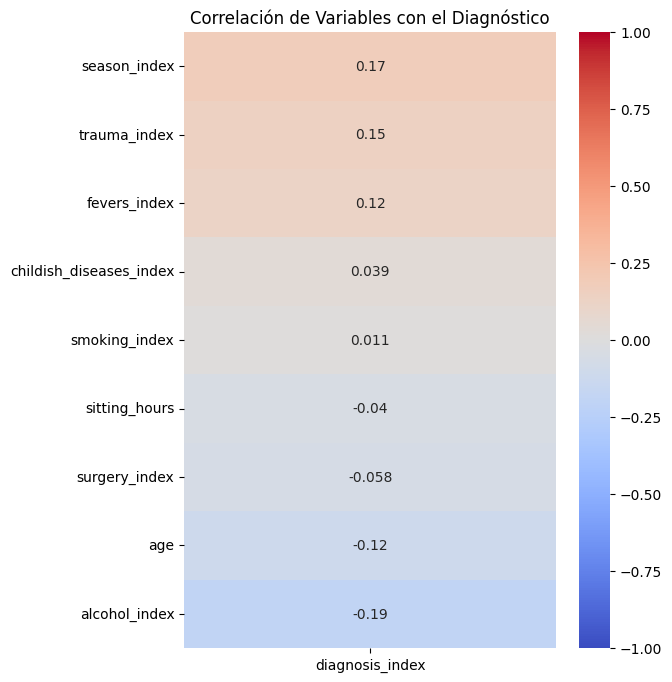

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("=== 5. ANÁLISIS DE CORRELACIÓN (FACTORES DE RIESGO) ===")

# 1. Convertir a Pandas
# Como son solo 100 datos, es seguro y más potente usar Pandas/Seaborn para esta matemática.
pdf = df_analysis.toPandas()

# 2. Calcular Matriz de Correlación (Método de Spearman para datos ordinales/categóricos)
# Usamos 'spearman' porque es mejor para rankings (como frecuencia de alcohol) que 'pearson'.
corr_matrix = pdf.corr(method='spearman')

# 3. Enfocarnos en el Target: ¿Qué correlaciona con el Diagnóstico?
# Extraemos solo la columna 'diagnosis_index' y ordenamos
target_corr = corr_matrix[['diagnosis_index']].drop('diagnosis_index') # Quitamos la correlación consigo mismo
target_corr = target_corr.sort_values(by='diagnosis_index', ascending=False)

print("Tabla de Correlación con el Diagnóstico (Ordenada por impacto):")
# Mostramos la tabla como pediste
print(target_corr)

# 4. (Opcional pero recomendado) Visualización Gráfica
plt.figure(figsize=(6, 8))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlación de Variables con el Diagnóstico")
plt.show()

In [0]:
# === REEMPLAZAR CELDA 6 CON ESTO ===
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

print("=== 6. MODELADO DE FACTORES COMPUESTOS ===")

# 1. Definir Features
feature_cols = ["age", "sitting_hours", 
                "season_index", "childish_diseases_index", "trauma_index", 
                "surgery_index", "fevers_index", "alcohol_index", "smoking_index"]

# 2. Vectorizar (Usando df_analysis que creamos en el paso 4)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_model_data = assembler.transform(df_analysis) 

# 3. Split Train/Test
train_data, test_data = df_model_data.randomSplit([0.7, 0.3], seed=42)

# 4. Entrenar Modelo
# Nota: LogisticRegression usa muy poca memoria comparado con StringIndexer, esto sí funcionará.
lr = LogisticRegression(labelCol="diagnosis_index", featuresCol="features")
lr_model = lr.fit(train_data)

# 5. Evaluar
predictions = lr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(
    labelCol="diagnosis_index", predictionCol="prediction", metricName="accuracy")

print(f"Precisión Global (Accuracy): {evaluator.evaluate(predictions):.2%}")

# 6. Ver Pesos
print("\n--- Peso de cada Variable ---")
for feature, weight in sorted(zip(feature_cols, lr_model.coefficients), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {weight:.4f}")

=== 6. MODELADO DE FACTORES COMPUESTOS ===
✅ Precisión Global (Accuracy): 82.86%

--- Peso de cada Variable ---
trauma_index: 0.9890
surgery_index: 0.9001
childish_diseases_index: 0.8370
alcohol_index: -0.6388
smoking_index: 0.4131
season_index: 0.3544
sitting_hours: -0.1783
age: -0.1336
fevers_index: -0.0464


## 5. Análisis: SQL vs Spark (PySpark)

Basado en la experiencia desarrollando este taller, se puede comparar ambos enfoques:

| Criterio | SQL (Spark SQL) | Spark (PySpark DataFrame API) |
| :--- | :--- | :--- |
| **Limpieza de Datos** | **Desventaja:** Renombrar 10 columnas con espacios en SQL requiere una query muy larga y propensa a errores de sintaxis (`SELECT "Col Name" as col_name...`). | **Ventaja:** El método `.withColumnRenamed` o `toDF()` permite limpiar esquemas de forma programática y ordenada antes de exponer la tabla. |
| **Exploración Rápida** | **Ventaja:** Comandos como `SELECT *` o `GROUP BY` son inmediatos de escribir y leer para cualquier analista. | **Neutral:** Requiere importar funciones (`col`, `count`, `avg`) y conocer la sintaxis de objetos. |
| **Tipado de Datos** | **Neutral:** Depende de la definición DDL al crear la tabla. | **Ventaja:** Al usar `StructType` en la lectura, pudimos forzar que `age` fuera Integer estrictamente, rechazando datos corruptos desde la entrada. |
| **Integración** | **Desventaja:** Limitado a consultas tabulares. | **Ventaja:** El DataFrame resultante puede pasarse fácilmente a librerías de Machine Learning (MLlib) para predecir la fertilidad. |

**Conclusión:**
Para este ejercicio, PySpark fue muy útil en la etapa de Ingesta, mientras que SQL fue superior en la etapa de consultas para validación.